# Notebook 2: Clustering & Markers

**Cell Annotation Pipeline - Part 2 of 3**

**Stages:** 5-7
**📥 Input:** `outputs/qc_filtered_data.h5ad`
**📤 Output:** `outputs/clustered_data.h5ad`
**➡️ Next:** `3_annotation_export.ipynb`

---


## Load Data from Notebook 1

Load the QC-filtered data and validate.

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load
print("Loading data from Notebook 1...")
adata = sc.read_h5ad('outputs/qc_filtered_data.h5ad')

# Validate
print("\n" + "="*60)
print("DATA VALIDATION")
print("="*60)

checks = {
    'QC metrics': 'percent_mt' in adata.obs.columns,
    'Doublet scores': 'doublet_score' in adata.obs.columns,
    'Sample info': 'orig.ident' in adata.obs.columns,
}

for check, passed in checks.items():
    print(f"  {'✓' if passed else '✗'} {check}")
    if not passed:
        raise ValueError(f"Missing {check} - run Notebook 1!")

print(f"\n✓ Loaded: {adata.n_obs:,} cells × {adata.n_vars:,} genes")


Loading data from Notebook 1...

DATA VALIDATION
  ✓ QC metrics
  ✓ Doublet scores
  ✓ Sample info

✓ Loaded: 16,188 cells × 19,608 genes


## Parameter Configuration

Set parameters for clustering.

In [4]:
# Clustering parameters
N_PCS = 33
N_NEIGHBORS = 10
CLUSTERING_PARAMS = {'resolution': 0.8}

# Create plots directory
PLOTS_DIR = Path('plots/notebook2')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("Parameters:")
print(f"  N_PCS: {N_PCS}")
print(f"  N_NEIGHBORS: {N_NEIGHBORS}")
print(f"  Resolution: {CLUSTERING_PARAMS['resolution']}")


Parameters:
  N_PCS: 33
  N_NEIGHBORS: 10
  Resolution: 0.8


## 7. Stage 5: Normalization & Scaling

Normalize counts to account for sequencing depth differences and identify highly variable genes.

**Steps:**
1. Save raw counts
2. Normalize total counts per cell to 10,000
3. Log-transform (log1p)
4. Identify highly variable genes (HVGs)
5. Scale data (zero mean, unit variance)

**No parameters to tune in this stage.**


NORMALIZATION AND SCALING
[1/5] Saving raw counts...
      ✓ Raw data saved

[2/5] Normalizing to 10,000 counts per cell...
      ✓ Normalized

[3/5] Log-transforming (log1p)...
      ✓ Log-transformed

[4/5] Identifying highly variable genes...
      ✓ Identified 2,019 highly variable genes



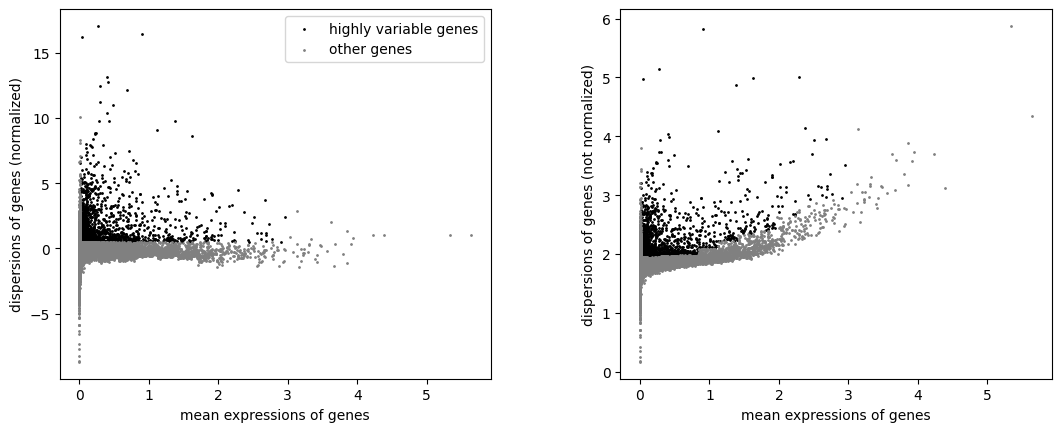

      ✓ HVG plot saved to plots/notebook2/highly_variable_genes.png

      Subset to 2,019 HVGs for downstream analysis

[5/5] Scaling data (zero mean, unit variance, max=10)...


/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/homebrew/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


      ✓ Data scaled

FINAL: 16,188 cells × 2,019 HVGs (scaled)
Raw data preserved: 16,188 cells × 19,608 genes


In [5]:
from pandas.core.frame import duplicated


def normalize_and_scale(adata):
    """Normalize and scale data
    
    This follows the standard scanpy workflow and matches the original pipeline.
    
    Args:
        adata: AnnData object
    
    Returns:
        Processed AnnData object
    """
    print("\n" + "="*60)
    print("NORMALIZATION AND SCALING")
    print("="*60)
    
    # Save raw counts
    print("[1/5] Saving raw counts...")
    adata.raw = adata
    print("      ✓ Raw data saved\n")
    
    # Normalize to 10,000 reads per cell
    print("[2/5] Normalizing to 10,000 counts per cell...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    print("      ✓ Normalized\n")
    
    # Log transform
    print("[3/5] Log-transforming (log1p)...")
    sc.pp.log1p(adata)
    print("      ✓ Log-transformed\n")
    
    # Find highly variable genes
    print("[4/5] Identifying highly variable genes...")
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    n_hvg = adata.var['highly_variable'].sum()
    print(f"      ✓ Identified {n_hvg:,} highly variable genes\n")
    
    # Plot highly variable genes
    sc.pl.highly_variable_genes(adata, show=False)
    plt.savefig(PLOTS_DIR / 'highly_variable_genes.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"      ✓ HVG plot saved to {PLOTS_DIR}/highly_variable_genes.png\n")
    
    # Keep only HVGs for downstream analysis
    adata = adata[:, adata.var.highly_variable]
    print(f"      Subset to {adata.n_vars:,} HVGs for downstream analysis\n")
    
    # Scale data
    print("[5/5] Scaling data (zero mean, unit variance, max=10)...")
    sc.pp.scale(adata, max_value=10)
    print("      ✓ Data scaled\n")
    
    print("="*60)
    print(f"FINAL: {adata.n_obs:,} cells × {adata.n_vars:,} HVGs (scaled)")
    print(f"Raw data preserved: {adata.raw.n_obs:,} cells × {adata.raw.n_vars:,} genes")
    print("="*60)
    
    return adata

# Normalize and scale
adata = normalize_and_scale(adata)

## Stage 6: PCA, UMAP & Clustering

Reduce dimensionality and identify cell clusters.

Running PCA...


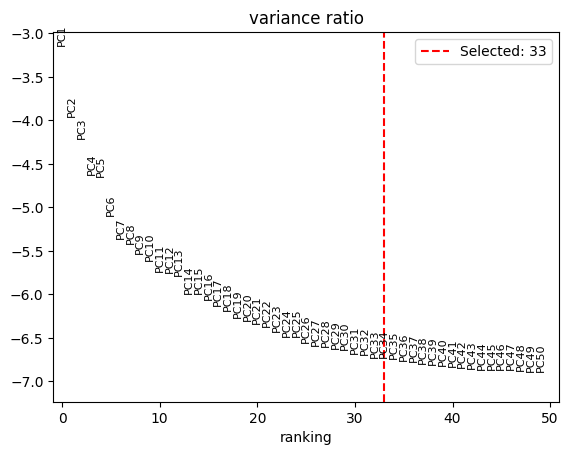

✓ Using 33 PCs


In [6]:
# Run PCA
print("Running PCA...")
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# Elbow plot
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, show=False)
plt.axvline(N_PCS, color='r', linestyle='--', label=f'Selected: {N_PCS}')
plt.legend()
plt.savefig(PLOTS_DIR / 'pca_elbow_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Using {N_PCS} PCs")


### 🎛️ Parameter Tuning Guide: PCA

Review the PCA elbow plot above. Where does the variance explained drop off?

---

#### **📊 PCA Elbow Patterns**

<details>
<summary><b>Clear elbow at PC 15-20:</b> Variance drops sharply after PC 20, then plateaus</summary>

**Diagnosis:** ✅ Ideal - clear signal-to-noise separation

**Action:**
```python
# In Cell 4 (Parameter Configuration), set:
N_PCS = 20  # Or 25 to be safe
```

**Reason:** PCs after 20 mainly capture noise, not biological variation

**Then:** Re-run from Stage 6 (Cell 8)
</details>

<details>
<summary><b>Variance decreases gradually (no clear elbow):</b> Smooth decrease from PC 1 to PC 50</summary>

**Diagnosis:** Complex dataset with many sources of variation

**Action:**
```python
N_PCS = 35  # Increase to capture more variation
# Or even:
N_PCS = 40  # For very complex tissues
```

**Reason:** Need more PCs to capture biological variation

**When this happens:**
- Heterogeneous tissue (many cell types)
- Multiple biological processes active
- Batch effects present (but not dominating)

**Then:** Re-run from Stage 6 (Cell 8)
</details>

<details>
<summary><b>Elbow at PC 10:</b> Sharp drop after PC 10</summary>

**Diagnosis:** ⚠️ Unusual - may indicate issues

**Possible causes:**
- Very homogeneous cell population
- Over-filtering removed diversity
- Technical issues (batch effects dominating first few PCs)

**Actions:**

1. **Use fewer PCs:**
```python
N_PCS = 10  # Or 12
```

2. **Investigate PC loadings** (check what genes load on PC 1-3)
3. **Review filtering** (was QC too stringent?)

**Then:** Re-run from Stage 6, validate after UMAP
</details>

<details>
<summary><b>Current N_PCS = 15 looks good</b></summary>

**Diagnosis:** ✅ Standard choice for most datasets

**Action:** Proceed to UMAP (Cell 10)
</details>

---

#### **💡 General PCA Guidelines**

**Typical values:**
- **Simple tissues** (1-3 cell types): 10-15 PCs
- **Standard complexity** (5-10 cell types): 15-25 PCs  
- **Complex tissues** (brain, immune): 25-40 PCs
- **Very complex/batch effects**: 40-50 PCs

**What happens if you choose wrong:**
- **Too few PCs:** Lose biological signal, clusters merge incorrectly
- **Too many PCs:** Include noise, clusters become fragmented

### 📚 How the Leiden Algorithm Works

The **Leiden algorithm** is a graph-based clustering method that groups cells based on their similarity in gene expression space. Here's how it works:

1. **Graph Construction**: After PCA and neighbor computation, cells are represented as nodes in a graph where edges connect similar cells (based on k-nearest neighbors in PCA space).

2. **Modularity Optimization**: The algorithm optimizes **modularity** - a measure of how well-separated clusters are. High modularity means:
   - Cells within a cluster are more similar to each other
   - Cells in different clusters are more different from each other

3. **Resolution Parameter**: The `resolution` parameter controls the granularity:
   - **Low resolution (0.2-0.5)**: Favors larger, coarser clusters (major cell types)
   - **Medium resolution (0.6-1.0)**: Balanced clustering (cell types + subtypes) ← *current setting*
   - **High resolution (1.0-2.0)**: Favors smaller, finer clusters (detailed subtypes)

4. **Iterative Refinement**: The algorithm iteratively:
   - Moves cells between clusters to improve modularity
   - Ensures all clusters are "well-connected" (no disconnected sub-clusters)
   - Stops when no further improvement is possible

**Why Leiden over other methods?**
- Guarantees well-connected clusters (unlike older Louvain algorithm)
- Faster and more accurate than hierarchical clustering
- Works well with high-dimensional single-cell data
- Resolution parameter provides intuitive control over cluster granularity

The number of clusters you get depends on both the `resolution` parameter and the inherent structure of your data - more heterogeneous datasets naturally form more clusters at the same resolution.


In [7]:
# Compute neighbors and UMAP
print("Computing neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=N_NEIGHBORS, n_pcs=N_PCS)

print("Running UMAP...")
sc.tl.umap(adata)

print("Clustering...")
sc.tl.leiden(adata, resolution=CLUSTERING_PARAMS['resolution'])

print(f"✓ Identified {adata.obs['leiden'].nunique()} clusters")


Computing neighborhood graph...


/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running UMAP...
Clustering...


/var/folders/tf/f0_f53l11hq_9x5t0_hxr66h0000gn/T/ipykernel_52415/1864577207.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=CLUSTERING_PARAMS['resolution'])


✓ Identified 21 clusters


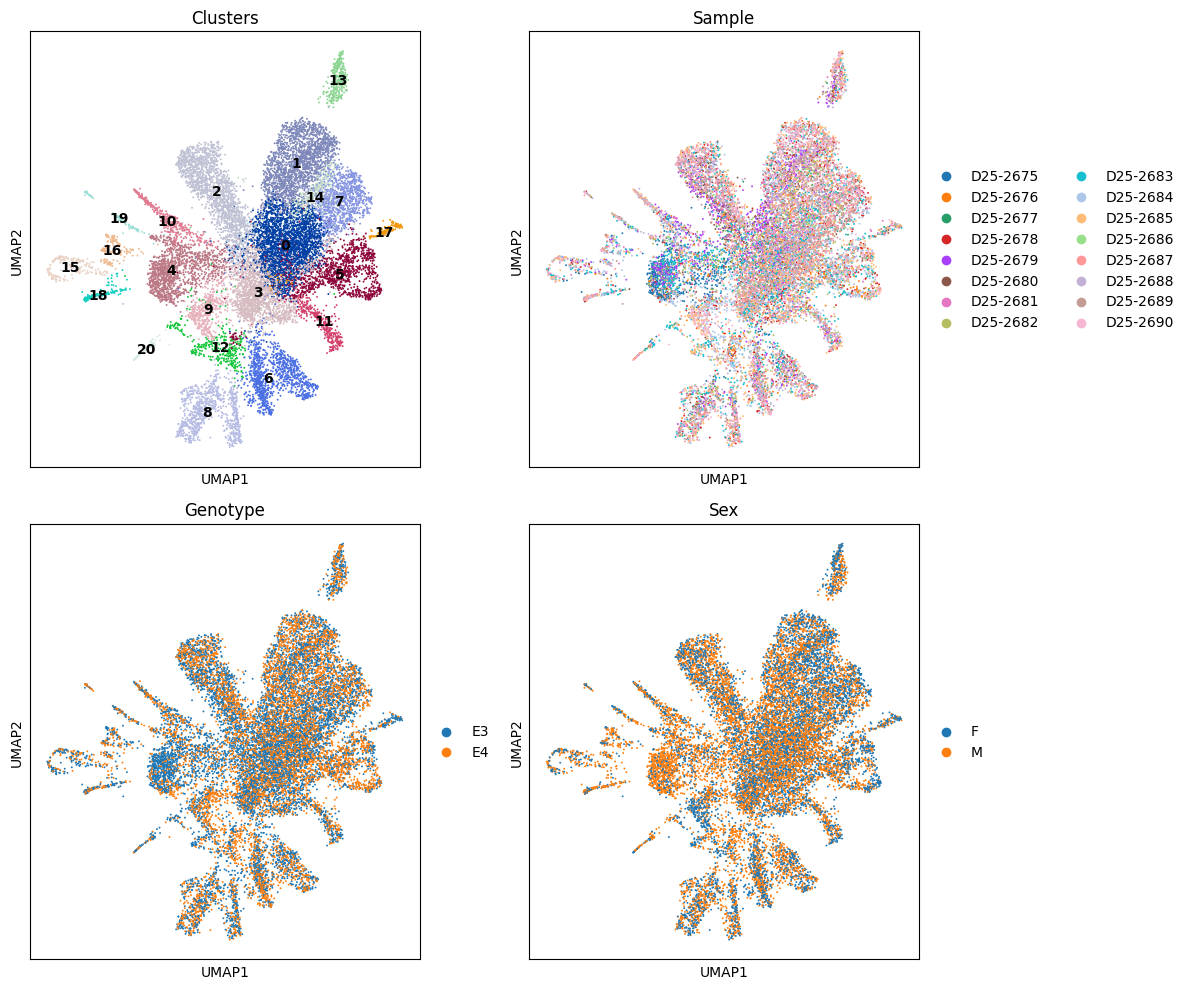

In [8]:
# Plot UMAP
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sc.pl.umap(adata, color='leiden', legend_loc='on data',
          title='Clusters', ax=axes[0,0], show=False)
sc.pl.umap(adata, color='orig.ident', title='Sample',
          ax=axes[0,1], show=False)
sc.pl.umap(adata, color='Genotype', title='Genotype',
          ax=axes[1,0], show=False)
sc.pl.umap(adata, color='Sex', title='Sex',
          ax=axes[1,1], show=False)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'umap_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()


## 🔍 How to Determine Optimal Leiden Resolution

The **resolution parameter** controls how granular your clustering will be. Choosing the right resolution is crucial for identifying biologically meaningful cell types.

### 📊 Two Approaches: Automatic vs Manual

#### **Option 1: Automatic Resolution Selection (Recommended)**

The pipeline includes an automatic resolution selection function that sweeps multiple resolutions and picks the optimal one based on:
- **Silhouette score** (cluster separation quality)
- **Small cluster fraction** (minimizes tiny, unstable clusters)
- **Number of clusters** (prefers moderate numbers)

**To use automatic selection:**

```python
# In Cell 3, update CLUSTERING_PARAMS:
CLUSTERING_PARAMS = {
    'resolution': None,  # Will be auto-selected
    'auto_resolution': True,  # Enable auto-selection
    'resolution_grid': None,  # Uses default: 0.2 to 2.0 (step 0.1)
    'min_cluster_size': 20,  # Minimum cells per cluster
}
```

**Then modify Cell 11 to use the automatic selection:**

```python
from utils.processing import choose_leiden_resolution

# ... existing code for neighbors and UMAP ...

# Automatic resolution selection
if CLUSTERING_PARAMS.get('auto_resolution', False):
    print("Performing Leiden resolution sweep...")
    chosen_res = choose_leiden_resolution(
        adata,
        resolution_grid=CLUSTERING_PARAMS.get('resolution_grid'),
        min_cluster_size=CLUSTERING_PARAMS.get('min_cluster_size', 20),
        save_dir=PLOTS_DIR / 'leiden_resolution_sweep'
    )
    CLUSTERING_PARAMS['resolution'] = chosen_res
    print(f"✓ Chosen resolution: {chosen_res}")
    adata.uns['leiden_optimal_resolution'] = chosen_res

# Cluster with chosen resolution
sc.tl.leiden(adata, resolution=CLUSTERING_PARAMS['resolution'])
```

**Outputs from automatic selection:**
- `plots/leiden_resolution_sweep/leiden_resolution_sweep.csv` - Metrics for each resolution
- `plots/leiden_resolution_sweep/leiden_sweep_diagnostics.png` - Plot showing silhouette and cluster count vs resolution
- `plots/leiden_resolution_sweep/clustree_leiden_labels.csv` - For visualization with clustree (optional)

**Interpreting the diagnostics plot:**
- **Silhouette score** (blue line): Higher is better (max = 1.0)
- **Number of clusters** (orange line): Should increase with resolution
- **Vertical dashed line**: Shows the automatically chosen resolution

---

#### **Option 2: Manual Resolution Selection**

If you prefer to choose resolution manually, follow these guidelines:

**Resolution ranges and their effects:**

| Resolution | Effect | Use Case |
|------------|--------|----------|
| **0.2 - 0.4** | Very coarse, few clusters | Initial exploration, major cell types only |
| **0.5 - 0.7** | Moderate, balanced | Most datasets, cell types + major subtypes |
| **0.8 - 1.0** | Fine-grained | Complex tissues, detailed subtypes |
| **1.2 - 2.0** | Very fine, many clusters | Highly heterogeneous samples, rare cell types |

**Step-by-step manual selection:**

1. **Start with a moderate resolution** (0.6-0.8)
2. **Examine the UMAP plot** - do clusters make biological sense?
3. **Check cluster sizes** - are there many tiny clusters (<20 cells)?
4. **Validate with markers** - do clusters have distinct marker genes?
5. **Adjust iteratively:**
   - **Too few clusters?** Increase resolution by 0.2-0.3
   - **Too many tiny clusters?** Decrease resolution by 0.2-0.3
   - **Clusters overlap on UMAP?** May need higher resolution
   - **Related cell types split?** May need lower resolution

**Example iterative process:**

```python
# Start
CLUSTERING_PARAMS['resolution'] = 0.6
# Run clustering, check results...

# Too few clusters? Increase
CLUSTERING_PARAMS['resolution'] = 0.8
# Run again...

# Too many small clusters? Decrease slightly
CLUSTERING_PARAMS['resolution'] = 0.7
# Run again...
```

---

### 🎯 What Makes a Good Resolution?

**Good clustering should have:**
1. **Biologically meaningful clusters** - each cluster represents a distinct cell type/subtype
2. **Reasonable cluster sizes** - most clusters have >50-100 cells (enough for DE analysis)
3. **Clear separation on UMAP** - clusters are visually distinct
4. **Distinct marker genes** - each cluster has unique top markers
5. **Stable across similar resolutions** - small changes in resolution don't drastically change clusters

**Red flags (adjust resolution if you see these):**
- Many clusters with <20 cells → **Decrease resolution**
- Clusters that should be separate are merged → **Increase resolution**
- Same cell type split into many clusters → **Decrease resolution**
- Clusters overlap heavily on UMAP → **Increase resolution**
- No clear biological meaning to clusters → **Try different resolution range**

---

### 💡 Pro Tips

1. **Use automatic selection first** - it's a great starting point, then fine-tune manually if needed
2. **Consider your tissue complexity** - brain tissue often needs 0.8-1.2, simpler tissues may need 0.4-0.6
3. **Check downstream needs** - if you need fine subtypes, use higher resolution; if you need broad types, use lower
4. **Validate with known markers** - the best resolution produces clusters that match known cell type markers
5. **Save your chosen resolution** - document it in your analysis notes for reproducibility

**Next steps:** After choosing resolution, proceed to marker gene analysis (Cell 14) to validate your clusters.

In [ ]:
# ============================================================================
# OPTIONAL: Automatic Leiden Resolution Selection
# ============================================================================
# 
# Uncomment and run this cell to automatically determine optimal resolution
# This will sweep resolutions from 0.2 to 2.0 and pick the best one
# 
# from utils.processing import choose_leiden_resolution
# 
# print("Performing Leiden resolution sweep...")
# print("This may take a few minutes...")
# 
# chosen_res = choose_leiden_resolution(
#     adata,
#     resolution_grid=None,  # Uses default: 0.2 to 2.0 (step 0.1)
#     min_cluster_size=20,   # Minimum cells per cluster
#     save_dir=PLOTS_DIR / 'leiden_resolution_sweep'
# )
# 
# print(f"\n✓ Optimal resolution: {chosen_res}")
# print(f"\nTo use this resolution, update Cell 3:")
# print(f"  CLUSTERING_PARAMS['resolution'] = {chosen_res}")
# print(f"\nThen re-run Cell 11 (clustering) to apply the new resolution.")
# 
# # Store in adata for reference
# adata.uns['leiden_optimal_resolution'] = chosen_res
# 
# # Optionally, update CLUSTERING_PARAMS and re-cluster immediately
# # CLUSTERING_PARAMS['resolution'] = chosen_res
# # sc.tl.leiden(adata, resolution=chosen_res)
# # print(f"\n✓ Re-clustered with resolution {chosen_res}")
# # print(f"  Number of clusters: {adata.obs['leiden'].nunique()}")

### 🎛️ Parameter Tuning Guide: UMAP & Clustering

Review the UMAP plots above. What patterns do you observe?

---

#### **📊 UMAP Structure**

<details>
<summary><b>Cells cluster by sample (not by cell type)</b></summary>

**Diagnosis:** ⚠️ Batch effects dominate biological signal

**Actions:**

1. **First try: Increase PCs**
```python
N_PCS = 35  # or 40
```
**Then:** Re-run from Stage 6 (Cell 8)

2. **If still present: Use batch correction** (Harmony, scVI, or Seurat)

**Note:** Some sample-specific clustering can be biological
</details>

<details>
<summary><b>UMAP shows no clear structure (cloud of points)</b></summary>

**Diagnosis:** ⚠️ Over-smoothing or insufficient variation

**Actions to try:**

**Approach 1: Lower neighbors**
```python
N_NEIGHBORS = 5  # Reduce smoothing
```

**Approach 2: Increase PCs**
```python
N_PCS = 30  # Capture more variation
```

**Then:** Re-run from Stage 6 (Cell 8)
</details>

<details>
<summary><b>UMAP shows many tiny scattered clusters</b></summary>

**Diagnosis:** ⚠️ Under-smoothing or low-quality cells

**Actions:**

**Increase neighbors:**
```python
N_NEIGHBORS = 20  # More smoothing
```

**Then:** Re-run from Stage 6 (Cell 8)
</details>

<details>
<summary><b>UMAP shows clear, separated clusters</b></summary>

**Diagnosis:** ✅ Good structure

**Action:** Proceed to examine cluster counts below
</details>

---

#### **📊 Number of Clusters**

<details>
<summary><b>&lt;5 clusters total</b></summary>

**Diagnosis:** ⚠️ Under-clustering

**Action:**
```python
CLUSTERING_PARAMS['resolution'] = 1.0  # Try this first
# If still too few:
CLUSTERING_PARAMS['resolution'] = 1.2  # Or higher
```

**Strategy:** Increase in steps: 0.8 → 1.0 → 1.2 → 1.5

**Then:** Re-run from Cell 10 (clustering only)
</details>

<details>
<summary><b>5-20 clusters</b></summary>

**Diagnosis:** ✅ Likely biologically meaningful

**Action:** 
1. Proceed to marker gene analysis (Cell 14)
2. Validate with known markers
</details>

<details>
<summary><b>&gt;30 clusters</b></summary>

**Diagnosis:** ⚠️ Over-clustering

**Action:**
```python
CLUSTERING_PARAMS['resolution'] = 0.6  # Try this first
# If still too many:
CLUSTERING_PARAMS['resolution'] = 0.4  # Lower further
```

**Strategy:** Decrease in steps: 0.8 → 0.6 → 0.4

**Then:** Re-run from Cell 10
</details>

---

#### **📊 Cluster Size Distribution**

<details>
<summary><b>Most clusters have &gt;100 cells</b></summary>

**Diagnosis:** ✅ Sufficient cells for differential expression

**Action:** Proceed to annotation (Notebook 3)
</details>

<details>
<summary><b>Many clusters have &lt;20 cells</b></summary>

**Diagnosis:** ⚠️ Over-clustering or low-quality singleton clusters

**Actions:**

1. **Decrease resolution:**
```python
CLUSTERING_PARAMS['resolution'] = 0.5
```

2. **Check if small clusters are doublets** (high counts, mixed markers)

**Then:** Re-run from Cell 10
</details>

<details>
<summary><b>One large cluster (&gt;50% of cells) and many tiny ones</b></summary>

**Diagnosis:** ⚠️ Uneven clustering

**Actions:**

**If large cluster is heterogeneous:**
```python
CLUSTERING_PARAMS['resolution'] = 1.2  # Increase
```

**If tiny clusters are low-quality:** Consider excluding them

**Then:** Re-run from Cell 10
</details>

---

#### **💡 Clustering Resolution Guidelines**

**Typical values:**
- **Coarse clustering** (major cell types): 0.2-0.5
- **Standard clustering** (cell types + subtypes): 0.6-1.0
- **Fine-grained** (detailed subtypes): 1.0-2.0

**For brain tissue:**
- Identifying neuron vs glia: 0.4-0.6
- Separating excitatory/inhibitory: 0.8-1.0
- Layer-specific neurons: 1.2-1.5

**Iterative approach:**
1. Start with 0.8 (default)
2. Check number and size of clusters
3. Validate with markers
4. Adjust as needed

## Stage 7: Marker Gene Analysis

Identify differentially expressed genes per cluster.

Computing marker genes...


/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/.venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/melissadu/Documents/proj

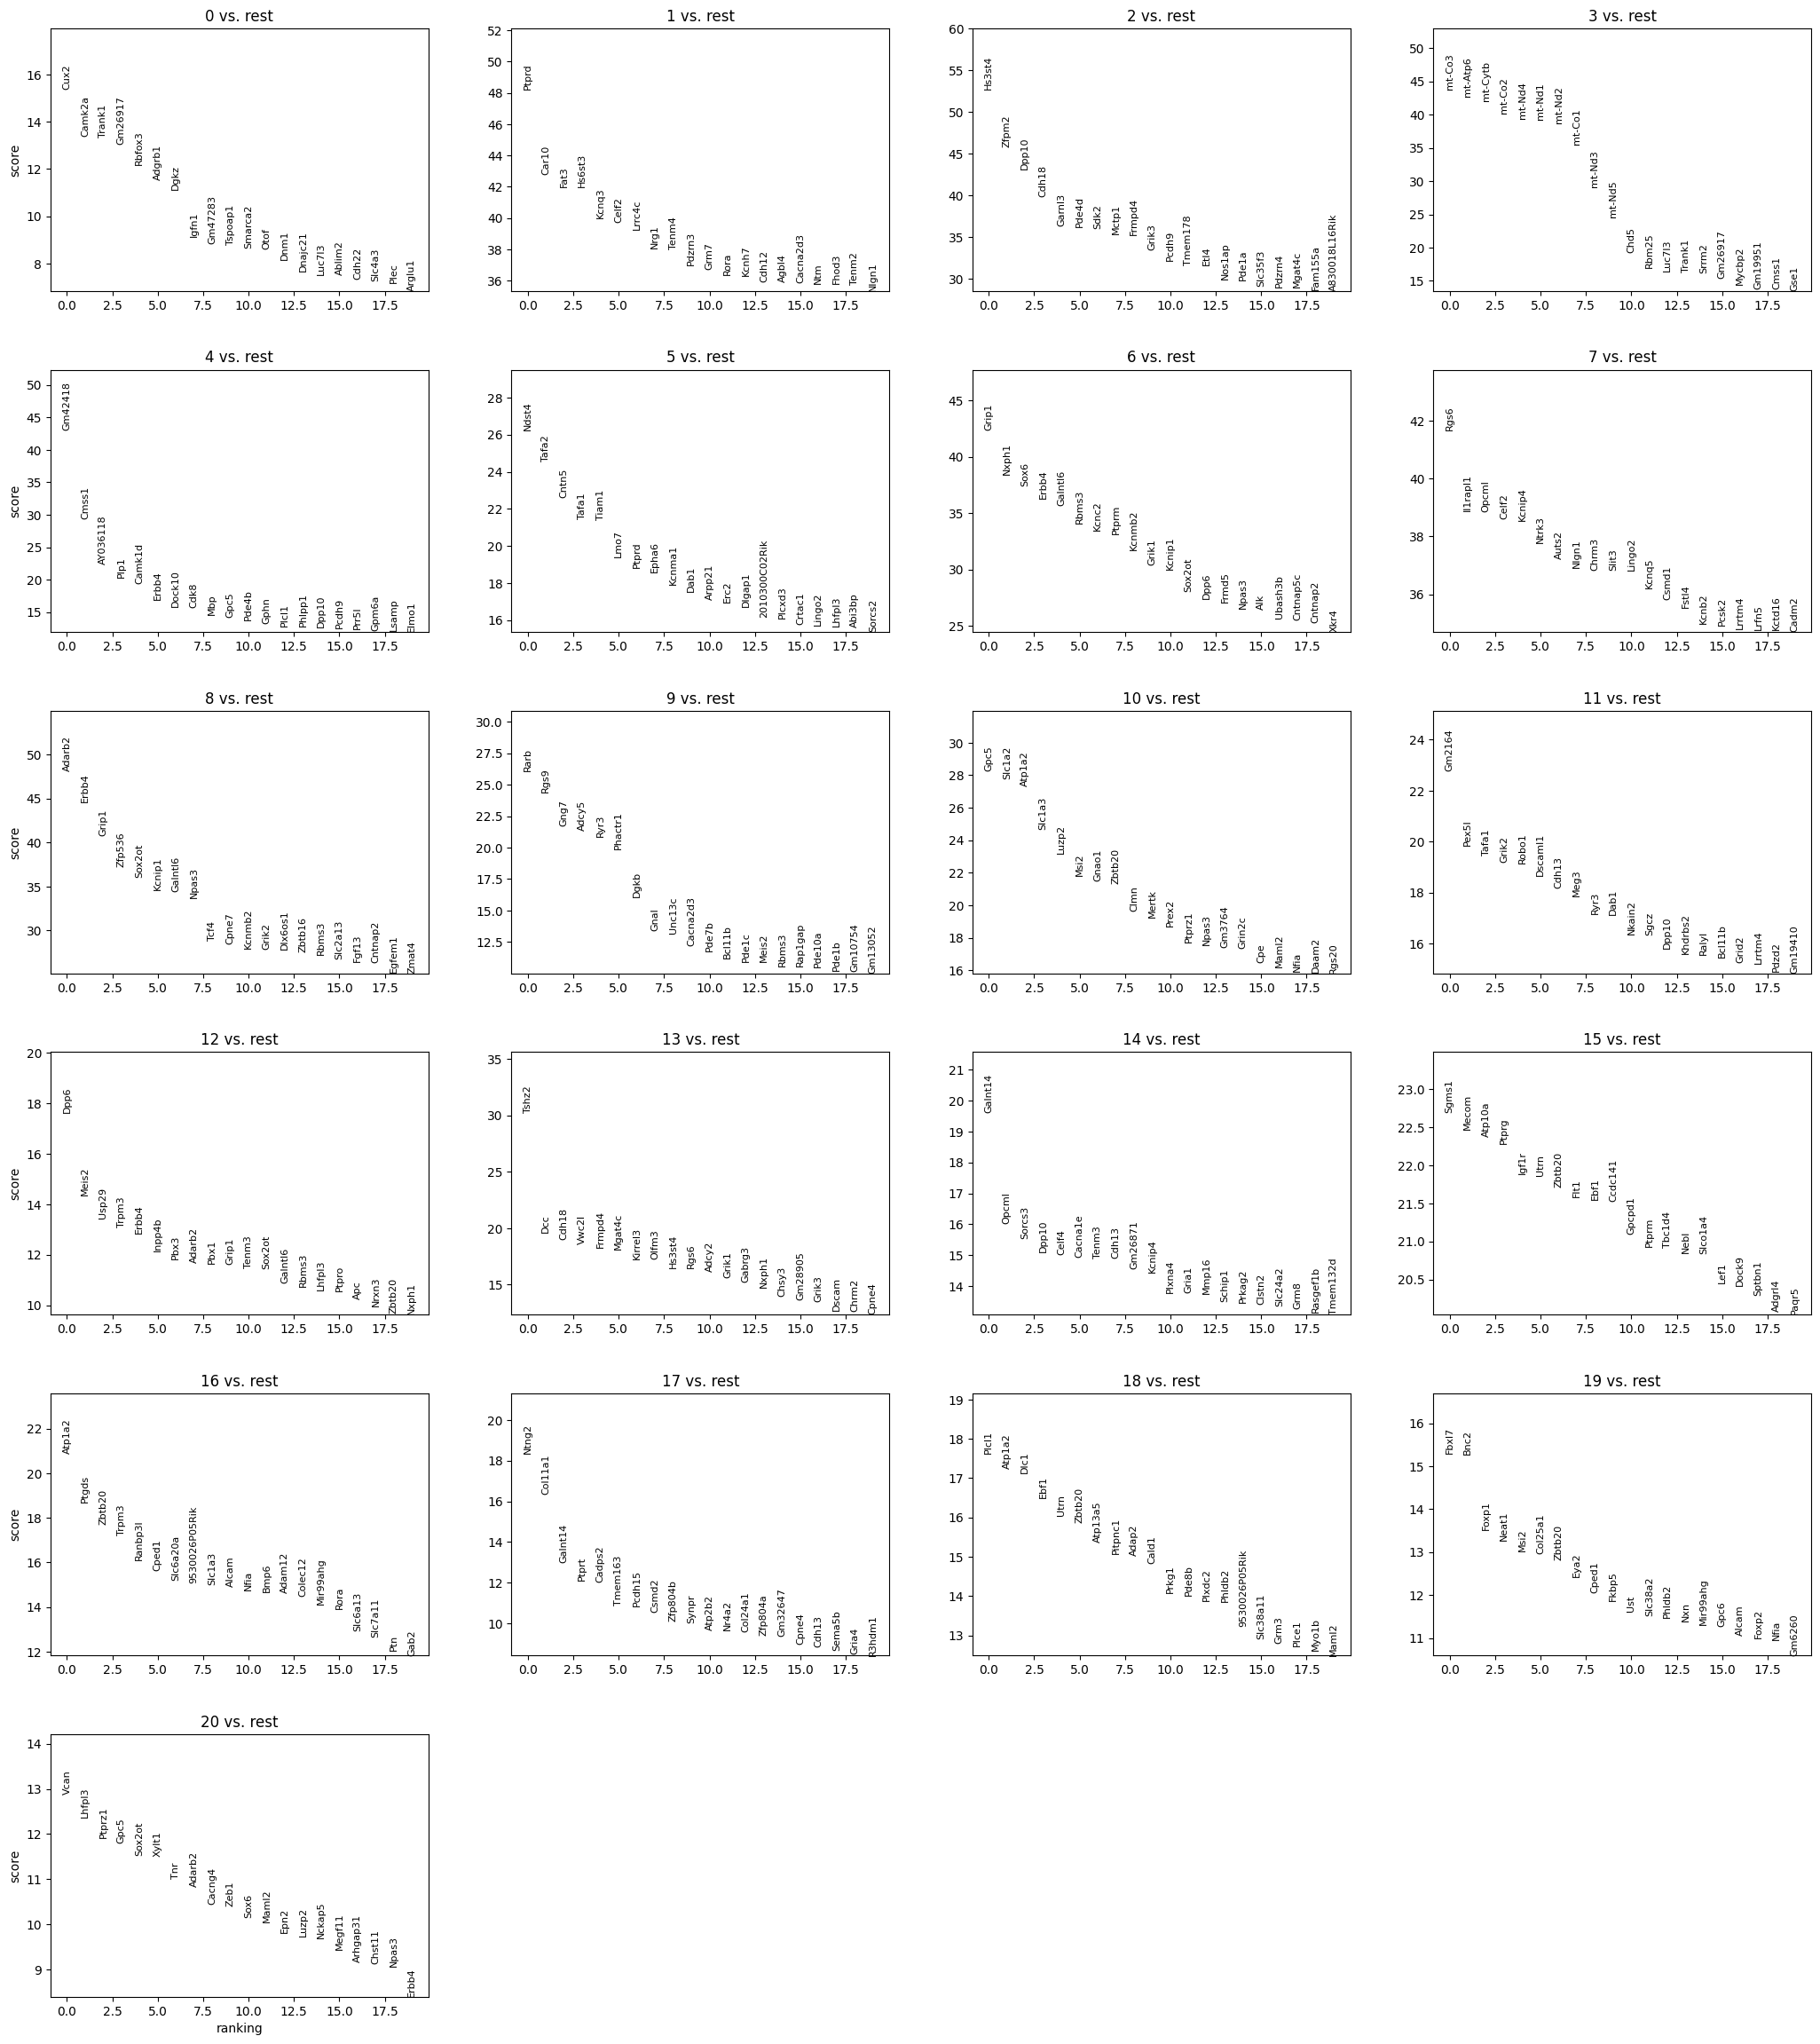

✓ Saved markers to top_markers_by_cluster.csv


In [9]:
# Compute markers
print("Computing marker genes...")
sc.tl.rank_genes_groups(adata, groupby='leiden',
                        method='wilcoxon', use_raw=True)

# Plot
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, show=False)
plt.savefig(PLOTS_DIR / 'top_marker_genes.png', dpi=300, bbox_inches='tight')
plt.show()

# Export to CSV
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

markers_dict = {}
for group in groups:
    markers_dict[f'Cluster_{group}_genes'] = result['names'][group][:30]
    markers_dict[f'Cluster_{group}_scores'] = result['scores'][group][:30]

markers_df = pd.DataFrame(markers_dict)
markers_df.to_csv(PLOTS_DIR.parent / 'top_markers_by_cluster.csv', index=False)

print(f"✓ Saved markers to top_markers_by_cluster.csv")


### 🎛️ Parameter Tuning Guide: Marker Gene Validation

Review the marker genes plot above. Check the top genes for each cluster.

---

#### **📊 Top Marker Gene Patterns**

<details>
<summary><b>Top markers are ribosomal/mitochondrial genes</b> (e.g., Rpl3, Rps5, mt-Co1, mt-Nd4)</summary>

**Diagnosis:** ⚠️ Low-quality cluster or stressed cells

**Actions:**

1. **Check cluster size** (likely small)
2. **Check QC metrics** for this cluster:
```python
# In notebook, add a cell:
cluster_id = '5'  # Replace with problematic cluster
print(adata[adata.obs['leiden'] == cluster_id].obs[['percent_mt', 'percent_ribo', 'n_genes_by_counts']].describe())
```

3. **If high MT%:** These are dying cells → Consider excluding this cluster

4. **If systematic:** Go back to Notebook 1, use stricter QC filters

**Decision:**
- If one small cluster: Exclude it post-hoc
- If multiple clusters: Re-run with stricter QC from Notebook 1
</details>

<details>
<summary><b>Top markers are cell cycle genes</b> (e.g., Mki67, Top2a, Cdk1)</summary>

**Diagnosis:** Proliferating cells

**Context-dependent:**
- **Expected** (neurogenesis, development, cancer): Keep cluster
- **Unexpected** (adult non-dividing tissue): Check if doublets or contamination

**Actions if unexpected:**
```python
# Check doublet scores for this cluster
cluster_id = '8'  # Replace with cluster number
print(adata[adata.obs['leiden'] == cluster_id].obs['doublet_score'].describe())
```

**Options:**
- Regress out cell cycle effects (advanced - requires re-processing)
- Keep cluster but annotate as "Proliferating"
- If doublets: Lower doublet threshold and re-run Notebook 1
</details>

<details>
<summary><b>Clusters have overlapping top markers</b> (e.g., Clusters 3 and 5 share 8/10 top markers)</summary>

**Diagnosis:** ⚠️ Over-clustering - these should probably be merged

**Actions:**

1. **Decrease resolution:**
```python
CLUSTERING_PARAMS['resolution'] = 0.6  # Lower
```
**Then:** Re-run from Cell 10

2. **Or merge clusters post-hoc in Notebook 3**

3. **Use hierarchical clustering** to identify mergeable clusters
</details>

<details>
<summary><b>Clusters have distinct, specific markers</b> (e.g., Cluster 1: Slc17a7, Camk2a; Cluster 2: Gad1, Gad2)</summary>

**Diagnosis:** ✅ Excellent - clear biological identities

**Interpretation:**
- Cluster 1: Excitatory neurons
- Cluster 2: Inhibitory neurons

**Action:** Proceed to Notebook 3 for annotation

**Validation tip:** Check if known markers appear:
- Do neuron clusters have Snap25?
- Do astrocyte clusters have Gfap or Aqp4?
- Do microglia clusters have P2ry12?
</details>

---

#### **📊 General Marker Validation**

**Good markers should:**
1. **Be specific** - not expressed in other clusters
2. **Be known genes** - recognizable, not just novel transcripts
3. **Make biological sense** - match expected cell types

**Red flags:**
- Ribosomal genes (Rpl*, Rps*)
- Mitochondrial genes (mt-*)
- Heat shock proteins (Hsp*)
- Hemoglobin genes (Hb*) - unless working with blood
- No recognizable markers - may indicate low-quality cells

**What to do next:**
1. Export the markers CSV (already done in Cell 14)
2. Look up unfamiliar markers in:
   - [GeneCards](https://www.genecards.org/)
   - [Mouse Genome Informatics](http://www.informatics.jax.org/)
   - [PanglaoDB](https://panglaodb.se/) (cell type markers)
3. Validate with known markers in Notebook 3

In [10]:
# Save clustered data
output_file = 'outputs/clustered_data.h5ad'

adata.uns['pipeline_params']['notebook'] = '2_clustering_markers'
adata.uns['pipeline_params']['n_pcs'] = N_PCS
adata.uns['pipeline_params']['n_neighbors'] = N_NEIGHBORS
adata.uns['pipeline_params']['clustering'] = CLUSTERING_PARAMS

adata.write(output_file)

print("\n" + "="*60)
print("NOTEBOOK 2 COMPLETE")
print("="*60)
print(f"✓ Saved: {output_file}")
print(f"  Clusters: {adata.obs['leiden'].nunique()}")
print("\n➡️  NEXT: Open 3_annotation_export.ipynb")



NOTEBOOK 2 COMPLETE
✓ Saved: outputs/clustered_data.h5ad
  Clusters: 21

➡️  NEXT: Open 3_annotation_export.ipynb
